This notebook analyses all transcipts downloaded via the scrape_episode_urls.py tool.

In [1]:
#all necessary imports
import glob
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
files = glob.glob('raw_data/*.csv')

In [48]:
import re
def getEpisodeNumber(item):
    m = re.search("(\d*)\.csv",item)
    return int(m.string[m.start(1):m.end(1)])

In [50]:
files.sort(key=getEpisodeNumber)

In [52]:
df_list = []
episode_number = 0
for f in files:
    df = pd.read_csv(f, sep=",", header=None, names=["Character", "Utterance"])
    episode_number += 1
    df["Episode"] = episode_number
    df_list.append(df)
    
transcripts = pd.concat(df_list, axis=0, ignore_index=True)

Analyse the number of **lines** per character

In [55]:
number_of_utterances_per_person = transcripts.groupby("Character").count()

In [56]:
top_15_characters_lines = number_of_utterances_per_person.sort_values(by="Utterance", ascending=False).head(15).reset_index()

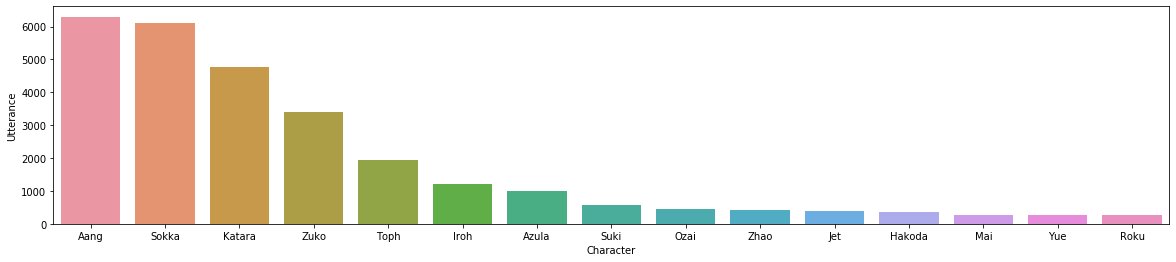

In [57]:
plt.figure(figsize=(20,4))
sns.barplot(x="Character", y="Utterance", data=top_15_characters_lines)

Analyse the number of **words** spoken per character

In [60]:
word_count = transcripts["Utterance"].apply(lambda x: len(x.split()))
transcripts_with_word_count = pd.concat([transcripts, word_count], axis=1)
transcripts_with_word_count.columns = ["Character", "Utterance", "Episode", "Wordcount"]

In [61]:
transcripts_with_word_count.head()

,Character,Utterance,Episode,Wordcount
0,Kya,"Water, earth, fire, air. My grandmother used t...",1,144
1,Aang,"Wahoo! Hang on, Momo.",1,4
2,Sokka,You idiot! We're about to die!,1,6
3,Kya,"Firebolt! Aang, focus!",1,3
4,Zuko,Again!,1,1


In [62]:
number_of_words_per_character = transcripts_with_word_count[["Character", "Wordcount"]].groupby("Character").sum()

In [63]:
top_15_characters_words = number_of_words_per_character.sort_values(by="Wordcount", ascending=False).head(15).reset_index()

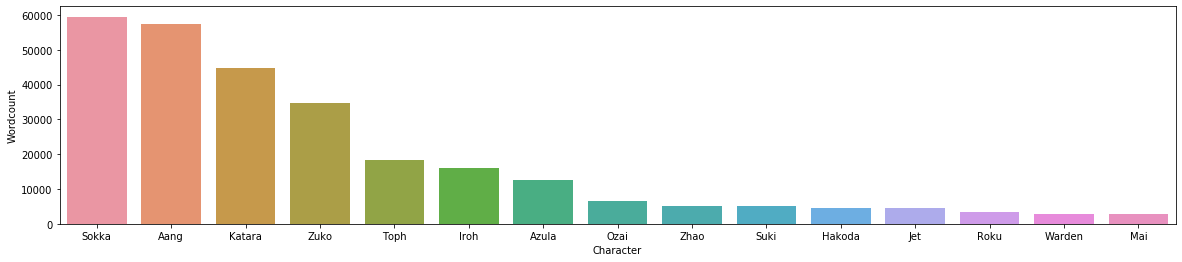

In [64]:
plt.figure(figsize=(20,4))
sns.barplot(x="Character", y="Wordcount", data=top_15_characters_words)

Load spacy's medium-sized English language model

In [65]:
nlp = spacy.load("en_core_web_md")

In [105]:
grouped_episodes = transcripts.groupby("Episode")
utterances_per_episode = []
for name, group in grouped_episodes:
    utterances_per_episode.append("\n".join(group["Utterance"].tolist()))

In [106]:
from collections import defaultdict
verb_count = defaultdict(int)
adj_count = defaultdict(int)
noun_count = defaultdict(int)

for episode in utterances_per_episode:
    doc = nlp(episode)
    verb_count = defaultdict(int)
    noun_count = defaultdict(int)
    for token in doc:
        # ignore stop words
        if token.is_stop:
            continue
        if token.pos_ == 'VERB':
            verb_count[token.lemma_] += 1
        if token.pos_ == 'ADJ':
            adj_count[token.lemma_] += 1
        if token.pos_ == 'NOUN':
            noun_count[token.lemma_] += 1

In [107]:
top_10_verbs = sorted(verb_count.items(), key=lambda kv: kv[1], reverse=True)[:10]
top_10_adjectives = sorted(adj_count.items(), key=lambda kv: kv[1], reverse=True)[:10]
top_10_nouns = sorted(noun_count.items(), key=lambda kv: kv[1], reverse=True)[:10]

<BarContainer object of 10 artists>

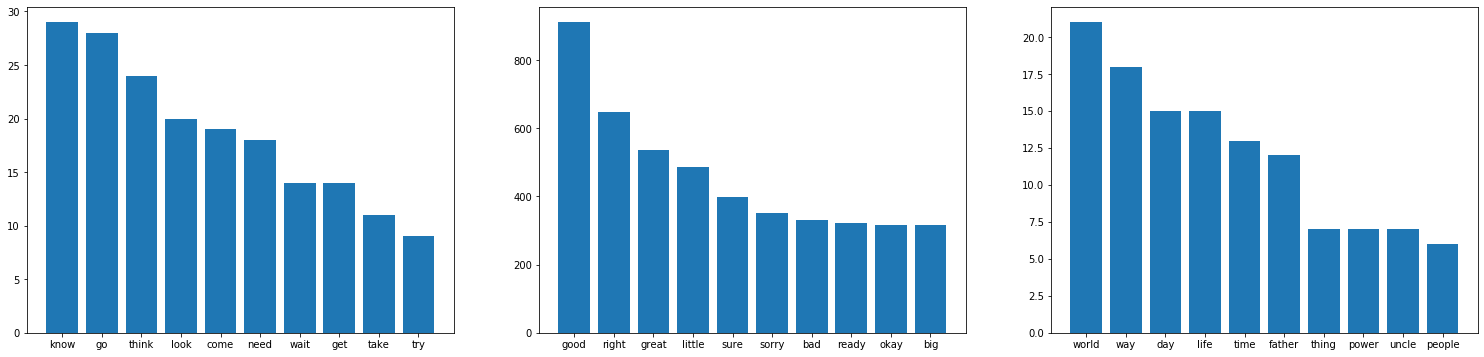

In [108]:
fig, axs = plt.subplots(1, 3, figsize=(26, 6))
axs[0].bar([x[0] for x in top_10_verbs], [x[1] for x in top_10_verbs])
axs[1].bar([x[0] for x in top_10_adjectives], [x[1] for x in top_10_adjectives])
axs[2].bar([x[0] for x in top_10_nouns], [x[1] for x in top_10_nouns])